In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2024-12-09 22:32:33.685922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [115]:
train_data = pd.read_csv("./data/train_images.csv")
test_data = pd.read_csv('./data/test_images_path.csv')
sample_submission = pd.read_csv("./data/test_images_sample.csv")

class_names = np.load("./data/class_names.npy", allow_pickle=True).item()
attributes = np.load("./data/attributes.npy")

#print(train_labels.head())

for bird in list(class_names.keys()):
    print(bird)

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
004.Groove_billed_Ani
005.Crested_Auklet
006.Least_Auklet
007.Parakeet_Auklet
008.Rhinoceros_Auklet
009.Brewer_Blackbird
010.Red_winged_Blackbird
011.Rusty_Blackbird
012.Yellow_headed_Blackbird
013.Bobolink
014.Indigo_Bunting
015.Lazuli_Bunting
016.Painted_Bunting
017.Cardinal
018.Spotted_Catbird
019.Gray_Catbird
020.Yellow_breasted_Chat
021.Eastern_Towhee
022.Chuck_will_Widow
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
026.Bronzed_Cowbird
027.Shiny_Cowbird
028.Brown_Creeper
029.American_Crow
030.Fish_Crow
031.Black_billed_Cuckoo
032.Mangrove_Cuckoo
033.Yellow_billed_Cuckoo
034.Gray_crowned_Rosy_Finch
035.Purple_Finch
036.Northern_Flicker
037.Acadian_Flycatcher
038.Great_Crested_Flycatcher
039.Least_Flycatcher
040.Olive_sided_Flycatcher
041.Scissor_tailed_Flycatcher
042.Vermilion_Flycatcher
043.Yellow_bellied_Flycatcher
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
047.American_Goldfinch
048.Eu

In [116]:
train_data.sample(20)

,image_path,label
1652,/train_images/1653.jpg,56
303,/train_images/304.jpg,11
2915,/train_images/2916.jpg,113
3715,/train_images/3716.jpg,171
3797,/train_images/3798.jpg,181
3380,/train_images/3381.jpg,142
3867,/train_images/3868.jpg,190
2525,/train_images/2526.jpg,93
1863,/train_images/1864.jpg,65
3544,/train_images/3545.jpg,155


In [117]:
print(train_data["label"].value_counts())

# Count of each class goes from 5 to 35
print("Min amount of times a class appears:", (train_data["label"].value_counts()).min())
print("Max amount of times a class appears:", (train_data["label"].value_counts()).max())

label
1      35
4      35
2      35
9      34
10     34
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64
Min amount of times a class appears: 5
Max amount of times a class appears: 35


In [118]:
train_data['class_name'] = train_data['label'].map(
    {v: k for k, v in class_names.items()}  # Reverse the dictionary to map label to class_name
)

train_data['class_name'] = [
    "_".join(name.split('.')[1].split('_')) for name in train_data['class_name']
]

train_data['image_path'] = 'data' + train_data['image_path']
train_data

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


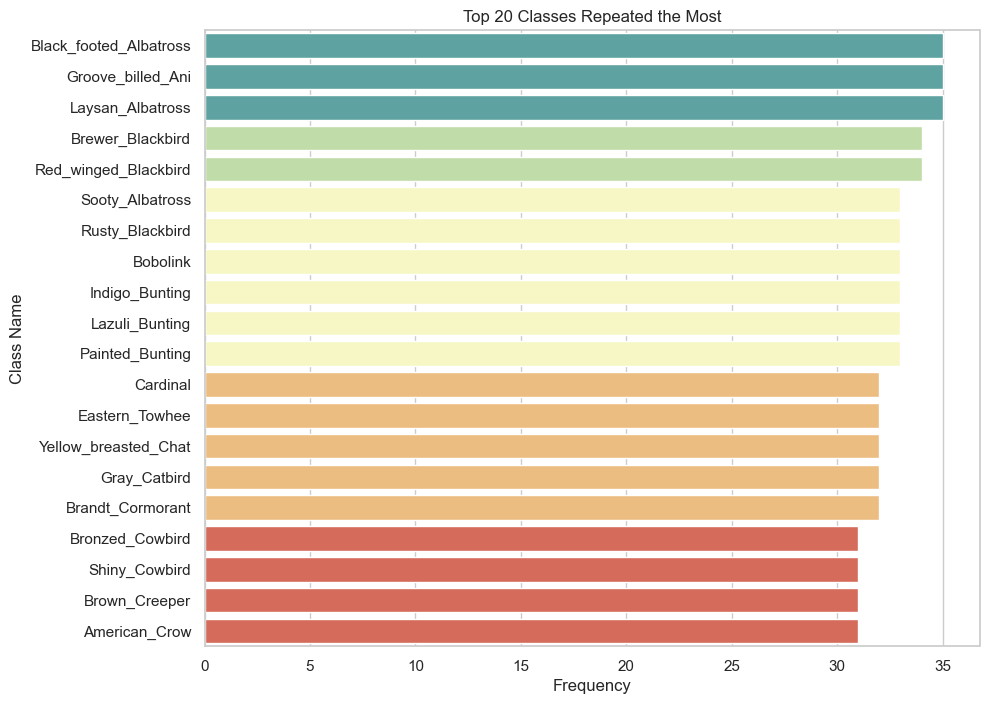

In [119]:
# Let's check beautifully which are the top 20 most repeated bird classes
top_20 = (train_data['class_name'].value_counts()[:20])

color_palette = sns.color_palette("Spectral", len(set(top_20.values)))
frequency_to_color = {freq: color for freq, color in zip(sorted(set(top_20.values)), color_palette)}
bar_colors = [frequency_to_color[freq] for freq in top_20.values]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_20.values,
    y=top_20.index,
    palette=bar_colors
)
plt.xlabel("Frequency")
plt.ylabel("Class Name")
plt.title("Top 20 Classes Repeated the Most")
plt.show()

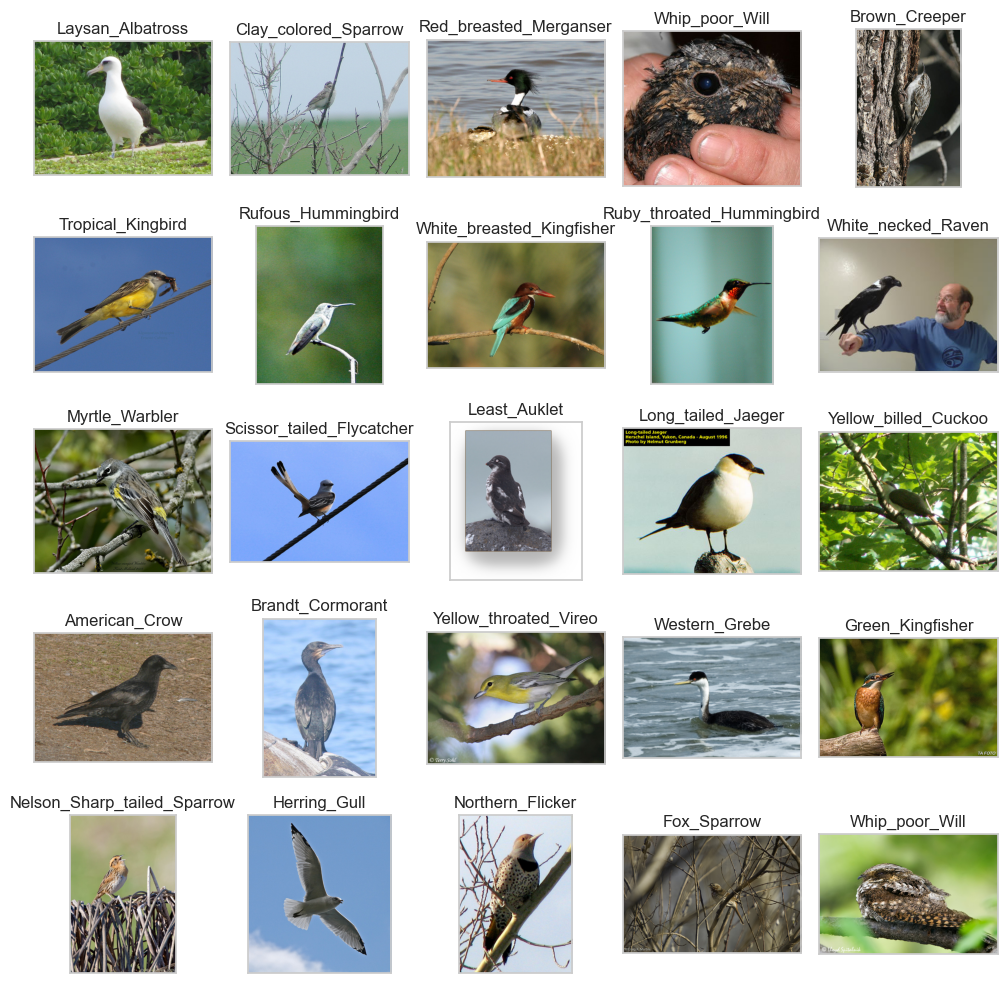

In [120]:
sample_df = train_data.sample(25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()):
    ax.imshow(plt.imread(row['image_path']))
    ax.set_title(row['class_name'])

plt.tight_layout()
plt.show()

In [121]:
attribute_names = []
with open('./data/attributes.txt', 'r') as f:
    for line in f:
        attribute_names.append(line.strip().split(' ')[1])  # Extract the name after the index

# Sanity check: print attribute names
print("Loaded attribute names:\n", attribute_names)

Loaded attribute names:
 ['has_bill_shape::curved_(up_or_down)', 'has_bill_shape::dagger', 'has_bill_shape::hooked', 'has_bill_shape::needle', 'has_bill_shape::hooked_seabird', 'has_bill_shape::spatulate', 'has_bill_shape::all-purpose', 'has_bill_shape::cone', 'has_bill_shape::specialized', 'has_wing_color::blue', 'has_wing_color::brown', 'has_wing_color::iridescent', 'has_wing_color::purple', 'has_wing_color::rufous', 'has_wing_color::grey', 'has_wing_color::yellow', 'has_wing_color::olive', 'has_wing_color::green', 'has_wing_color::pink', 'has_wing_color::orange', 'has_wing_color::black', 'has_wing_color::white', 'has_wing_color::red', 'has_wing_color::buff', 'has_upperparts_color::blue', 'has_upperparts_color::brown', 'has_upperparts_color::iridescent', 'has_upperparts_color::purple', 'has_upperparts_color::rufous', 'has_upperparts_color::grey', 'has_upperparts_color::yellow', 'has_upperparts_color::olive', 'has_upperparts_color::green', 'has_upperparts_color::pink', 'has_upperparts

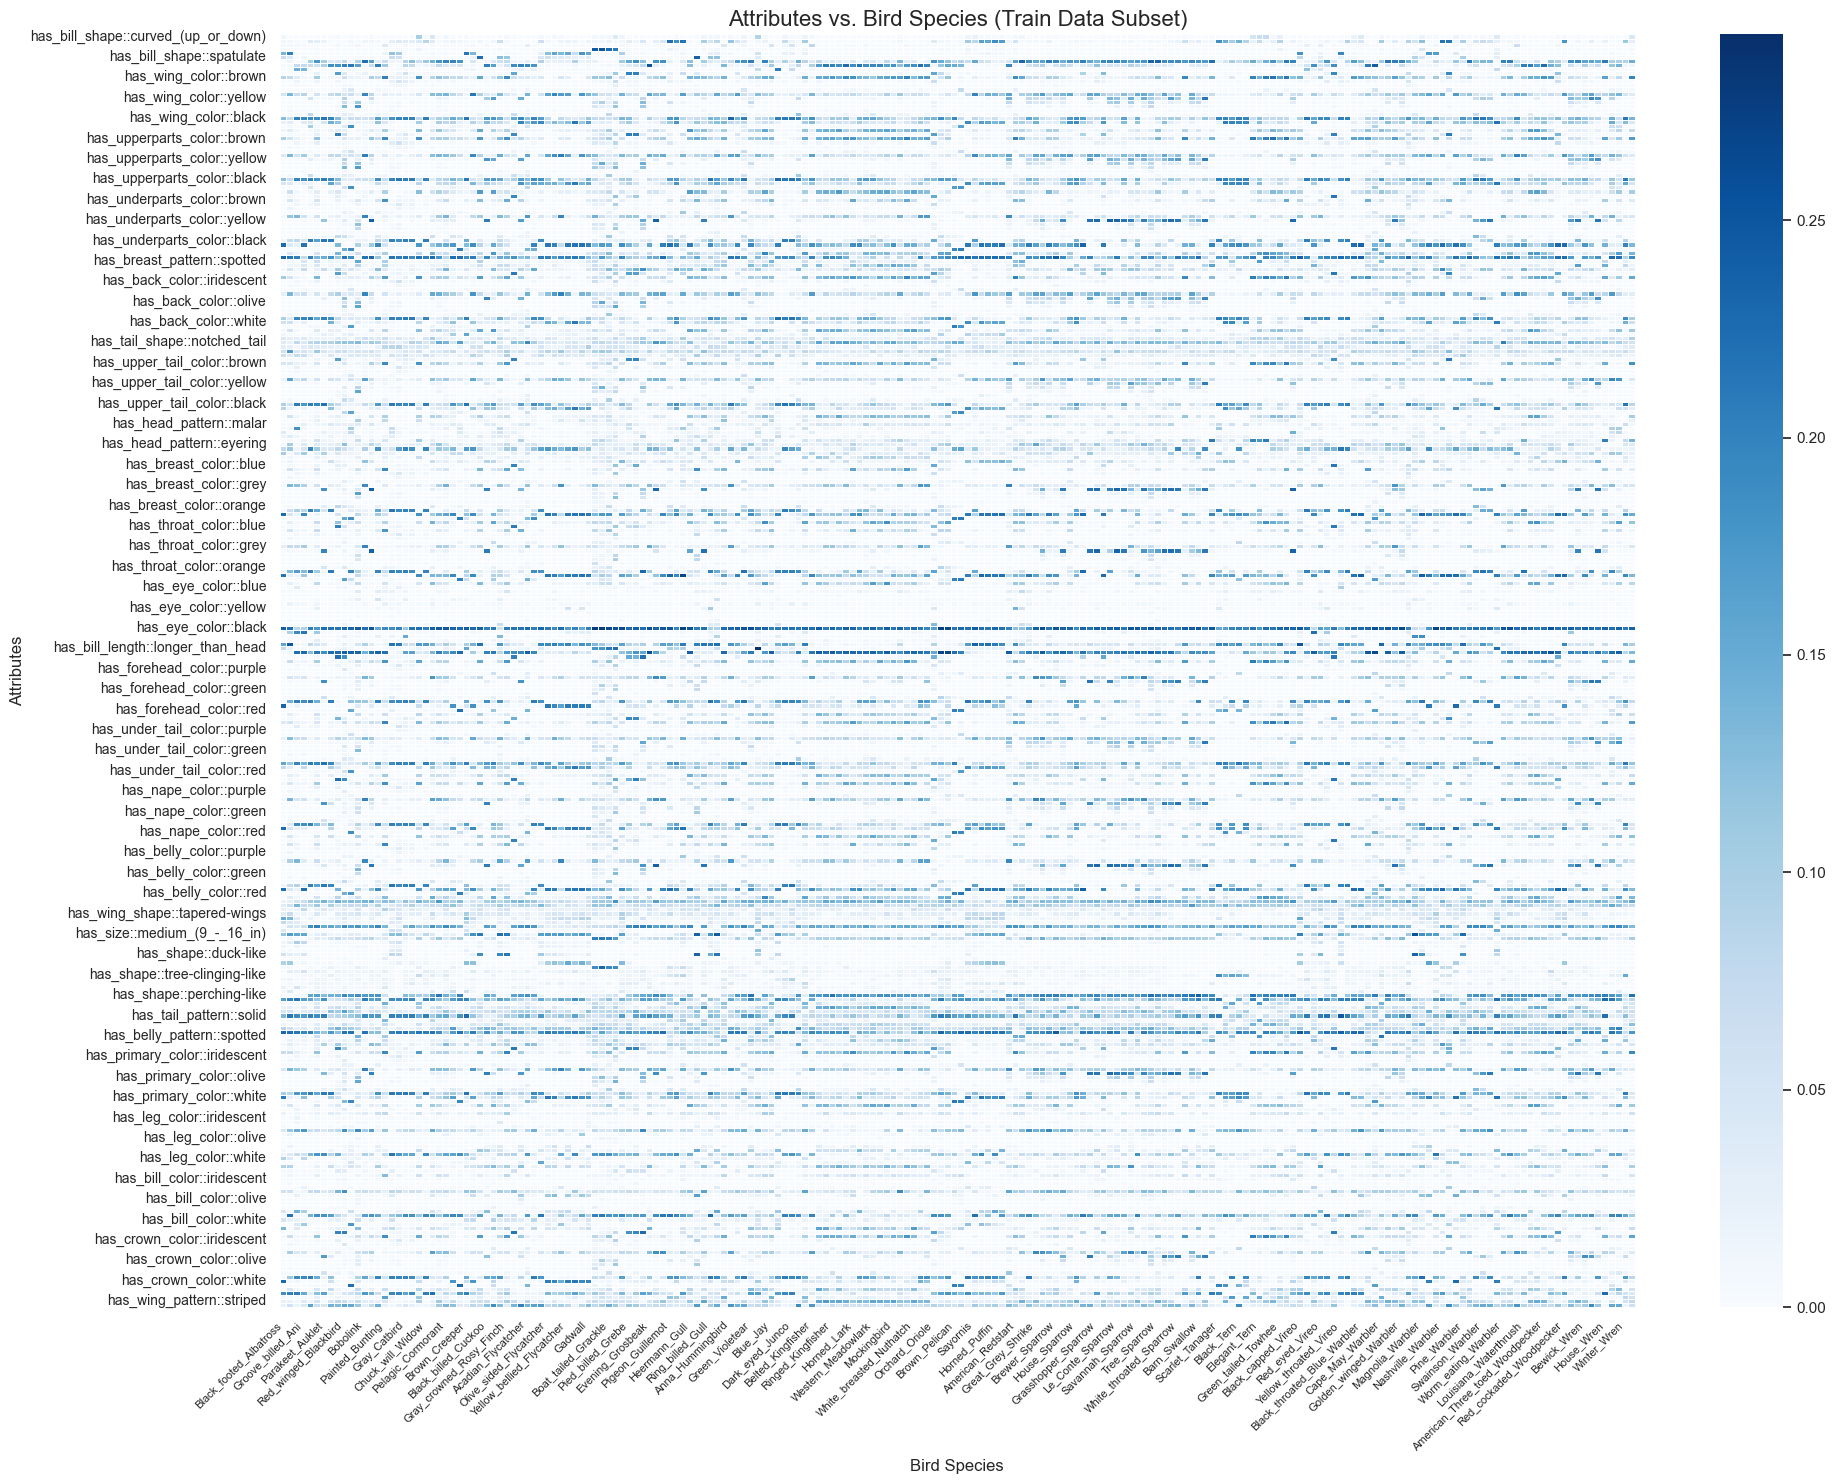

In [122]:
class_name_to_label = {row['class_name']: row['label'] for _, row in train_data.iterrows()}

att_matrix = pd.DataFrame(attributes, columns=attribute_names)
att_matrix.index = [
    class_name for class_name, label in class_name_to_label.items()
    if label <= len(attribute_matrix)
]

species = train_data['class_name'].unique()
matrix = attribute_matrix.loc[species]

# heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(matrix.T, cmap="Blues", cbar=True, linewidths=0.5)

plt.title("Attributes vs. Bird Species (Train Data Subset)", fontsize=16)
plt.xlabel("Bird Species", fontsize=12)
plt.ylabel("Attributes", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Processing #

In [123]:
train_data

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


In [124]:
image_size = (224, 224)
batch_size = 32

# augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# validation rescaling
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [137]:
train_df, val_df = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

### no attributes ###

In [138]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3140 validated image filenames belonging to 200 classes.
Found 786 validated image filenames belonging to 200 classes.


# Pytorch #

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load CSV data
train_df = pd.read_csv("./data/train_images.csv")
test_df = pd.read_csv("./data/test_images_path.csv")

train_df['image_path'] = 'data' + train_df['image_path']
test_df['image_path'] = 'data' + test_df['image_path']

# Paths
train_dir = "./data/train_images"  # Directory for training images
test_dir = "./data/test_images"    # Directory for test images

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0/255.0, 1.0/255.0, 1.0/255.0))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0/255.0, 1.0/255.0, 1.0/255.0))
])


Using cpu device


In [41]:
def prepare_data(df, transform):
    images = []
    labels = []
    for _, row in df.iterrows():
        image = Image.open(row['image_path']).convert("RGB")
        image = transform(image)
        images.append(image)
        labels.append(row['label'] - 1)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

train_images, train_labels = prepare_data(train_df, train_transform)

In [43]:
train_labels.max()

tensor(199)

In [25]:
def prepare_test_data(df, transform):
    images = []
    paths = []
    for _, row in df.iterrows():
        image = Image.open(row['image_path']).convert("RGB") 
        image = transform(image)
        images.append(image)
        paths.append(row['image_path'])
    images = torch.stack(images)
    return images, paths

test_images, test_paths = prepare_test_data(test_df, test_transform)

In [26]:
# DataLoader
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
# CNN model (ewwww why classesssssss)
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [30]:
num_classes = 200 
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#model

In [ ]:
from torch import nn, optim
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image

# Split into Training and Validation Sets
train_indices, val_indices = train_test_split(range(len(train_images)), test_size=0.2, random_state=42)
train_dataset = Subset(TensorDataset(train_images, train_labels), train_indices)
val_dataset = Subset(TensorDataset(train_images, train_labels), val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Definition
class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(self.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(self.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 200
# Instantiate Model, Loss, Optimizer, and Scheduler
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)

# Validation Function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / len(val_loader.dataset)
    return val_loss / len(val_loader), accuracy

# Training Loop with Early Stopping
num_epochs = 10
best_val_loss = float('inf')
patience = 5
no_improvement = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/10
Train Loss: 7.8533, Validation Loss: 5.2945, Validation Accuracy: 0.38%
Epoch 2/10
Train Loss: 5.2914, Validation Loss: 5.2916, Validation Accuracy: 0.25%
Epoch 3/10
Train Loss: 5.2815, Validation Loss: 5.2856, Validation Accuracy: 0.38%
Epoch 4/10
Train Loss: 5.2743, Validation Loss: 5.2823, Validation Accuracy: 0.38%
Epoch 5/10
Train Loss: 5.2742, Validation Loss: 5.2788, Validation Accuracy: 0.38%
